<a href="https://colab.research.google.com/github/limestonestreams/thesis/blob/master/BERT_preprocessing_(sudan).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

To wrap output text, applies to every cell. (from https://stackoverflow.com/questions/58890109/line-wrapping-in-collaboratory-google-results)

In [ ]:
from IPython.display import HTML, display

def set_css():
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  '''))
get_ipython().events.register('pre_run_cell', set_css)

Connecting to google drive:

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Importing dictionary of datasets for each topic:

In [ ]:
import pickle
import pandas as pd

with open('/content/gdrive/My Drive/Colab files/all_datasets', 'rb') as f:
   d = pickle.load(f)

In [ ]:
conflicts = ['Afghanistan', 'Albania', 'Angola', 'Bosnia-Herzegovina', 'Burundi', 'Central African Republic', 'Colombia', 'Croatia', 'DR Congo (Zaire)', 'El Salvador', 'Georgia', 'Guatemala', 'Guinea-Bissau', 'Haiti', 'Honduras', 'Iraq', 'Lebanon', 'Liberia', 'Macedonia, FYR', 'Mali', 'Myanmar (Burma)', 'Papua New Guinea', 'Rwanda', 'Serbia (Yugoslavia)', 'Sierra Leone', 'Somalia', 'Sudan', 'Tajikistan', 'Uganda', 'Ukraine', 'Venezuela']

#remove from the dictionary and the conflict array countries with no events
for i in conflicts:
    if 1 not in set(d[str(i).lower()]['event']): 
      del d[str(i).lower()]
      conflicts.remove(i)

In [ ]:
for i in conflicts:
  k = str(i).lower()
  d[k]['meeting'] = d[k]['meeting'].fillna(0)
  print(i)
  print(d[k]['meeting'].value_counts())

#Sudan, DRC, and Angola look good to run predictions on.
#Sudan, Iraq, Afghanistan

Afghanistan
0.0    34533
1.0      445
Name: meeting, dtype: int64
Angola
0.0    2941
1.0      35
Name: meeting, dtype: int64
Burundi
0.0    9099
1.0      55
Name: meeting, dtype: int64
Central African Republic
0.0    8631
1.0      71
Name: meeting, dtype: int64
Colombia
0.0    1358
1.0      18
Name: meeting, dtype: int64
Croatia
0.0    961
1.0      7
Name: meeting, dtype: int64
DR Congo (Zaire)
0.0    9978
1.0     106
Name: meeting, dtype: int64
Georgia
0.0    5266
1.0      18
Name: meeting, dtype: int64
Guinea-Bissau
0.0    7071
1.0      42
Name: meeting, dtype: int64
Haiti
0.0    8981
1.0      54
Name: meeting, dtype: int64
Iraq
0.0    10961
1.0      120
Name: meeting, dtype: int64
Lebanon
0.0    3231
1.0       6
Name: meeting, dtype: int64
Liberia
0.0    8530
1.0      37
Name: meeting, dtype: int64
Macedonia, FYR
0.0    1927
1.0       8
Name: meeting, dtype: int64
Mali
0.0    2662
1.0      44
Name: meeting, dtype: int64
Myanmar (Burma)
0.0    4969
1.0      13
Name: meeting, dtype: i

In [ ]:
data_sud = d['sudan']

data_sud = data_sud[data_sud['word_count'] >= 250]

data_sud['word_count'].describe()

count      217.000000
mean      4770.041475
std       4290.766725
min        285.000000
25%       1100.000000
50%       2435.000000
75%       9257.000000
max      14672.000000
Name: word_count, dtype: float64

(array([730120., 730851., 731581., 732312., 733042., 733773., 734503.,
        735234., 735964., 736695., 737425.]),
 <a list of 11 Text major ticklabel objects>)

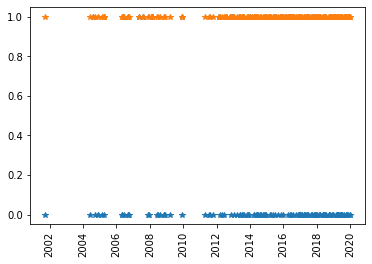

In [ ]:
import matplotlib.pyplot as plt 

plt.plot(data_sud['date'], data_sud['event'], '*')
plt.plot(data_sud['date'], data_sud['meeting'], '*')
plt.xticks(rotation = 'vertical')

In [ ]:
data_sud.drop_duplicates(inplace = True)
data_sud = data_sud.reset_index(drop = True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Changing event column so that it reflects whether there is an event in the 3 days following the speech:

In [ ]:
import numpy as np

i = 0
data_sud['label'] = ''
while i+4 <= len(data_sud.index):
    data_sud.iloc[i, 6] = np.where(sum(data_sud.iloc[i+1:i+4, 5]) > 0, 1, 0)
    i = i + 1

In [ ]:
data_sud['label'].value_counts()

1    124
0     60
       3
Name: label, dtype: int64

Formatting columns in the format BERT expects:

In [ ]:
#for data_drc

del data_sud['meeting']
del data_sud['date']
del data_sud['topic']
del data_sud['word_count']
del data_sud['event']

In [ ]:
data_sud = data_sud.dropna().reset_index(drop = True)
data_sud = data_sud.iloc[0:184,:]
data_sud

,text,label
0,the russian delegation is satisfied with the\n...,1
1,"the\nsecurity council, in this vote, has demon...",1
2,"\nthe humanitarian situation in darfur, in the...",0
3,"algeria\nhas been following attentively, and w...",0
4,it gives me\ngreat pleasure to begin by welcom...,1
...,...,...
179,in accordance with\nparagraph 3 (a) (iv) of re...,1
180,"i assume you,\nmr. president, are sharing your...",1
181,i thank\nunder-secretary-general lacroix and s...,1
182,i am sure that i\nspeak on behalf of my co-pen...,1


In [ ]:
train = data_sud
train['label'] = train['label'].astype(int)

From https://github.com/ArmandDS/bert_for_long_text/blob/master/final_bert_long_docs.ipynb:

Importing libraries:

In [ ]:
%tensorflow_version 1.x

import pandas as pd
import numpy as np
np.random.seed(1337)
from keras import Sequential
from keras.utils import Sequence
from keras.layers import LSTM, Dense, Masking
import numpy as np
import keras
from keras.utils import np_utils
from keras import optimizers
from keras.models import Sequential, Model
from keras.layers import Embedding, Dense, Input, concatenate, Layer, Lambda, Dropout, Activation
import datetime
from datetime import datetime
from keras.callbacks import ModelCheckpoint, EarlyStopping, Callback, TensorBoard
import tensorflow as tf
import tensorflow_hub as hub

import tensorflow
print(tensorflow.__version__)

TensorFlow 1.x selected.


Using TensorFlow backend.


1.15.2


In [ ]:
train = train.reindex(np.random.permutation(train.index))
train.head()

,text,label
25,may i begin\nby saying that the united kingdom...,0
36,"i thank\nyou, sir, for giving me the opportuni...",0
32,"at the\noutset, i wish to congratulate you mos...",0
43,we welcome the adoption of\nresolution 2075 (2...,1
154,in accordance with\nparagraph 3 (a) (iv) of re...,1


Clean the text columns:

In [ ]:
import re
def clean_txt(text):
  text = re.sub("'", "", text)
  #text=re.sub("(\\W)+"," ",text)
  text = re.sub(r'\n', ' ', text)    
  return text

train['text']  = train.text.apply(clean_txt)
train.head()

,text,label
25,may i begin by saying that the united kingdom ...,0
36,"i thank you, sir, for giving me the opportunit...",0
32,"at the outset, i wish to congratulate you most...",0
43,we welcome the adoption of resolution 2075 (20...,1
154,in accordance with paragraph 3 (a) (iv) of res...,1


Splitting into train and test set:

In [ ]:
from sklearn.model_selection import train_test_split

train, val = train_test_split(train, test_size = 0.2, random_state = 35)
train

,text,label
84,i am pleased and honoured to address the counc...,1
123,i would like to thank the prosecutor for her t...,1
175,in accordance with paragraph 3 (a) (iv) of res...,1
73,as this is the first time that i am addressing...,0
69,"i thank ms. fatou bensouda, prosecutor of the ...",0
...,...,...
70,as this is the first time that my delegation a...,0
167,i would like to take this opportunity to congr...,0
153,allow me to thank under- secretary-general lac...,0
1,"the security council, in this vote, has demons...",1


In [ ]:
train['label'].dtypes

dtype('int64')

In [ ]:
train.reset_index(drop = True, inplace = True)
val.reset_index(drop = True, inplace = True)

In [ ]:
val.shape, train.shape

((37, 2), (147, 2))

In [ ]:
print("Training Set Shape :", train.shape)
print("Validation Set Shape :", val.shape)
# print("Test Set Shape :", test.shape)

Training Set Shape : (147, 2)
Validation Set Shape : (37, 2)


In [ ]:
DATA_COLUMN = 'text'
LABEL_COLUMN = 'label'
# The list containing all the classes (train['SECTION'].unique())
label_list = [x for x in np.unique(train.label)]
label_list

[0, 1]

Splitting the data into smaller chunks:

In [ ]:
def get_split(text1):
  l_total = []
  l_parcial = []
  if len(text1.split())//150 >0:
    n = len(text1.split())//150
  else: 
    n = 1
  for w in range(n):
    if w == 0:
      l_parcial = text1.split()[:200]
      l_total.append(" ".join(l_parcial))
    else:
      l_parcial = text1.split()[w*150:w*150 + 200]
      l_total.append(" ".join(l_parcial))
  return l_total

In [ ]:
train['text_split'] = train[DATA_COLUMN].apply(get_split)
train.head()

,text,label,text_split
0,i am pleased and honoured to address the counc...,1,[i am pleased and honoured to address the coun...
1,i would like to thank the prosecutor for her t...,1,[i would like to thank the prosecutor for her ...
2,in accordance with paragraph 3 (a) (iv) of res...,1,[in accordance with paragraph 3 (a) (iv) of re...
3,as this is the first time that i am addressing...,0,[as this is the first time that i am addressin...
4,"i thank ms. fatou bensouda, prosecutor of the ...",0,"[i thank ms. fatou bensouda, prosecutor of the..."


In [ ]:
val['text_split'] = val[DATA_COLUMN].apply(get_split)
val.head(2)

,text,label,text_split
0,"i assume you, mr. president, are sharing your ...",1,"[i assume you, mr. president, are sharing your..."
1,i would like to thank the prosecutor of the in...,1,[i would like to thank the prosecutor of the i...


In [ ]:
train_l = []
label_l = []
index_l =[]
for idx,row in train.iterrows():
  for l in row['text_split']:
    train_l.append(l)
    label_l.append(row['label'])
    index_l.append(idx)
len(train_l), len(label_l), len(index_l)

(4356, 4356, 4356)

In [ ]:
val_l = []
val_label_l = []
val_index_l = []
for idx,row in val.iterrows():
  for l in row['text_split']:
    val_l.append(l)
    val_label_l.append(row['label'])
    val_index_l.append(idx)
len(val_l), len(val_label_l), len(val_index_l)

(1250, 1250, 1250)

The final dataset for training:

In [ ]:
train_df = pd.DataFrame({DATA_COLUMN:train_l, LABEL_COLUMN:label_l})
train_df.head()

,text,label
0,i am pleased and honoured to address the counc...,1
1,resolutions or statements pertaining to south ...,1
2,"society organizations, youth, women and politi...",1
3,"globe, in particular in africa. the splm-io al...",1
4,detainees. the president called upon the splm-...,1


And the final dataset for validation:

In [ ]:
val_df = pd.DataFrame({DATA_COLUMN:val_l, LABEL_COLUMN:val_label_l})
val_df.head()

,text,label
0,"i assume you, mr. president, are sharing your ...",1
1,in choosing the path that they are now on. i a...,1
2,"in particular the armed movements, to engage c...",1
3,secretary-general of the united nations (s/201...,1
4,let me just say here that the united kingdom w...,1


Saving pre-processed datasets for training and validation:

In [54]:
import pickle

with open('/content/gdrive/My Drive/Colab files/bert_training_df_sudan', 'wb') as f:
   pickle.dump(train_df, f)

with open('/content/gdrive/My Drive/Colab files/bert_validation_df_sudan', 'wb') as f:
   pickle.dump(val_df, f)   